This notebook is to show the variability of the EUV intensity in AIA images

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import glob
import numpy as np
import pandas as pd
from sunpy.sun import constants as const
import astropy.units as u
from sunpy.net import Fido
from sunpy.net import attrs as a
from astropy.coordinates import SkyCoord
from sunpy.coordinates import Helioprojective
import matplotlib.pyplot as plt
import sunpy.map
from sunpy.coordinates import RotatedSunFrame
from sunpy.coordinates import frames, get_body_heliographic_stonyhurst, get_horizons_coord
from matplotlib.patches import ConnectionPatch
import matplotlib
import numpy as np
import astropy.io.fits as fits
from astropy.visualization import ImageNormalize, PercentileInterval, SqrtStretch
from aiapy.calibrate import normalize_exposure, register, update_pointing

plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [2]:
year = '2021'
month = '09'
day = '18'

# result = Fido.search(a.Time(f'{year}-{month}-{day} 00:00:00',
#                             f'{year}-{month}-{day} 23:59:59'),
#                      a.Instrument('AIA'),
#                      a.Wavelength(193*u.angstrom),
#                      a.Sample(1*u.min))

# aia_files = Fido.fetch(result, path='./{instrument}/{file}')

aia_files = sorted(glob.glob(f'./AIA/AIA/*193*_{year}_{month}_{day}*lev1.fits'))
print(len(aia_files))

In [ ]:
# test
sunpy.map.Map(aia_files[60*20]).peek()

In [ ]:
# test

aiamap = sunpy.map.Map(aia_files[0])
point = SkyCoord(554*u.arcsec, 2*u.arcsec, frame=aiamap.coordinate_frame)

fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection=aiamap)
aiamap.plot(axes=ax, vmin=0, vmax=3e3)
ax.plot_coord(point, 'ro', fillstyle='none', markersize=16)
plt.show()

In [ ]:
# test

# We can differentially rotate this coordinate by using `RotatedSunFrame` with an array of observation times. Let’s define a daily cadence for +/- five days.
# durations = np.concatenate([range(1, 6), range(1, 20)])*u.hour
durations = range(1, 20, 2)*u.hour
diffrot_point = SkyCoord(RotatedSunFrame(base=point, duration=durations))

# To see what this coordinate looks like in “real” helioprojective Cartesian coordinates, we can transform it back to the original frame. Since these coordinates are represented in the original frame, they will not account for the changing position of the observer over this same time range.
transformed_diffrot_point = diffrot_point.transform_to(aiamap.coordinate_frame)

# plot the map with the points
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111, projection=aiamap)
aiamap.plot(axes=ax, vmin=0, vmax=3e3)

ax.plot_coord(point, 'ro', fillstyle='none', markersize=12, label='Original')
ax.plot_coord(transformed_diffrot_point, 'bo', fillstyle='none', markersize=12, label='Rotated')

ax.legend()
plt.show()

In [ ]:
# test

map1 = sunpy.map.Map(aia_files[0])
map1_updated_pointing = update_pointing(map1)
map1_registered = register(map1_updated_pointing)
map1_normalized = normalize_exposure(map1_registered)

map = sunpy.map.Map(aia_files[60*20])
map_updated_pointing = update_pointing(map)
map_registered = register(map_updated_pointing)
map_normalized = normalize_exposure(map_registered)

map2 = sunpy.map.Map(aia_files[-1])
map2_updated_pointing = update_pointing(map2)
map2_registered = register(map2_updated_pointing)
map2_normalized = normalize_exposure(map2_registered)

In [ ]:
fig = plt.figure(figsize=[22,10])

ax = fig.add_subplot(131, projection=map1_normalized)
m1 = map1_normalized.plot(axes=ax, vmin=0, vmax=3000)
plt.colorbar(m1, shrink=0.6, pad=0.01)

ax.plot_coord(point, 'ro', fillstyle='none', markersize=12)
ax.plot_coord(transformed_diffrot_point, 'bo', fillstyle='none', markersize=12)

ax = fig.add_subplot(132, projection=map_normalized)
m = map_normalized.plot(axes=ax, vmin=0, vmax=3000)
plt.colorbar(m, shrink=0.6, pad=0.01)

ax.plot_coord(point, 'ro', fillstyle='none', markersize=12)
ax.plot_coord(transformed_diffrot_point[-1], 'bo', fillstyle='none', markersize=12)

ax = fig.add_subplot(133, projection=map2_normalized)
m2 = map2_normalized.plot(axes=ax, vmin=0, vmax=3000)
plt.colorbar(m2, shrink=0.6, pad=0.01)

fig.tight_layout()
plt.show()

### Start from here ...

Mean intensity at that bright spot is: 146.61353605096267 DN.


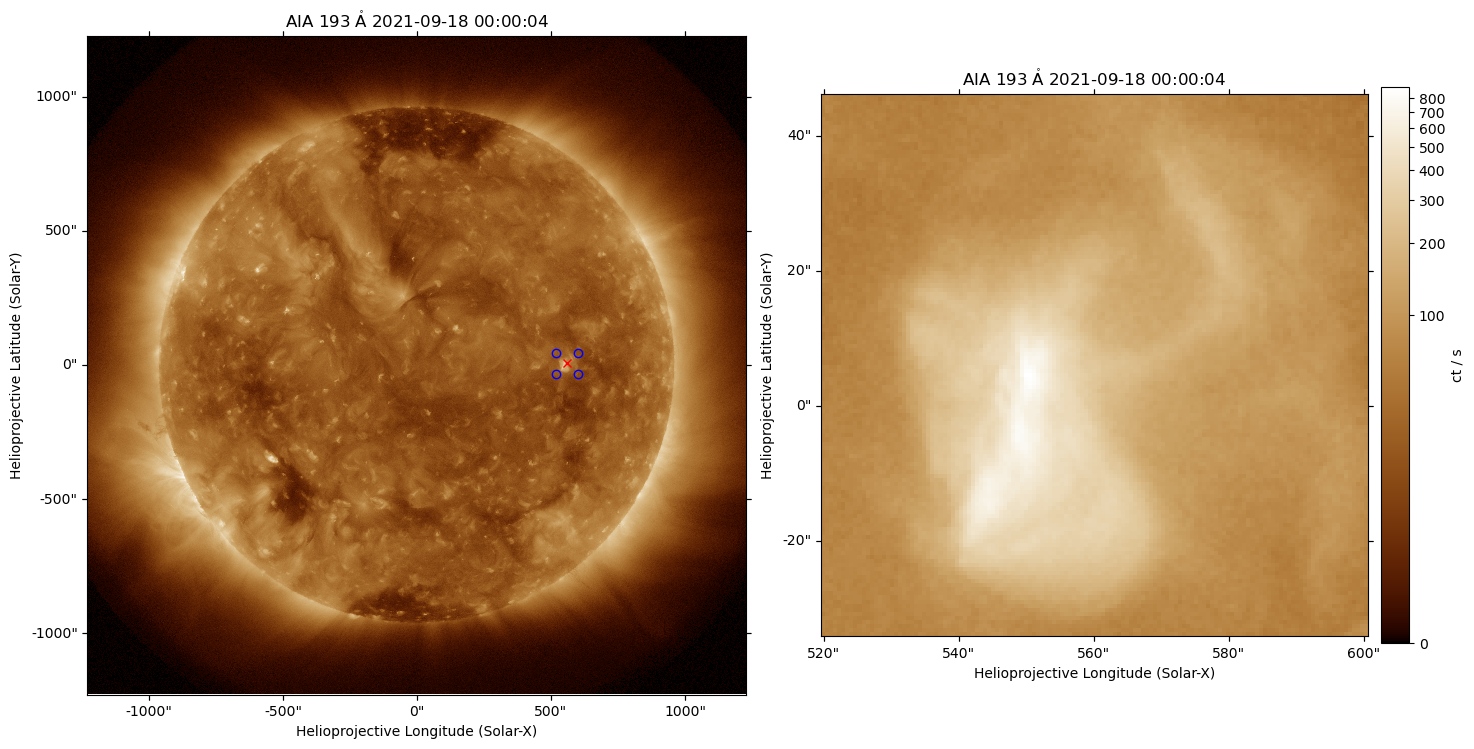

In [3]:
# load and calibrate the map
aiamap = sunpy.map.Map(aia_files[0])
aiamap_updated_pointing = update_pointing(aiamap)
aiamap_registered = register(aiamap_updated_pointing)
aiamap_normalized = normalize_exposure(aiamap_registered)

# We can differentially rotate this coordinate by using `RotatedSunFrame` with an array of observation times. Let’s define a daily cadence for +/- five days.
center_point = SkyCoord(560*u.arcsec, 6*u.arcsec, frame=aiamap_normalized.coordinate_frame)
increment = 40*u.arcsec
duration = range(1, len(aia_files), 1)*u.minute

top_left  = SkyCoord(center_point.Tx - increment, center_point.Ty + increment, frame=aiamap_normalized.coordinate_frame)
top_right = SkyCoord(center_point.Tx + increment, center_point.Ty + increment, frame=aiamap_normalized.coordinate_frame)

bottom_left  = SkyCoord(center_point.Tx - increment, center_point.Ty - increment, frame=aiamap_normalized.coordinate_frame)
bottom_right = SkyCoord(center_point.Tx + increment, center_point.Ty - increment, frame=aiamap_normalized.coordinate_frame)

diffrot_center_point = SkyCoord(RotatedSunFrame(base=center_point, duration=duration))

diffrot_topleft_point  = SkyCoord(RotatedSunFrame(base=top_left, duration=duration))
diffrot_topright_point = SkyCoord(RotatedSunFrame(base=top_right, duration=duration))

diffrot_bottomleft_point  = SkyCoord(RotatedSunFrame(base=bottom_left, duration=duration))
diffrot_bottomright_point = SkyCoord(RotatedSunFrame(base=bottom_right, duration=duration))

# To see what this coordinate looks like in “real” helioprojective Cartesian coordinates, we can transform it back to the original frame.
# Since these coordinates are represented in the original frame, they will not account for the changing position of the observer over this same time range.
# transformed_diffrot_point = diffrot_point.transform_to(aiamap_normalized.coordinate_frame)

# plot the map with the points
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(121, projection=aiamap_normalized)
aiamap_normalized.plot(axes=ax, vmin=0)
ax.grid(b=False)

ax.plot_coord(center_point, 'rx', fillstyle='none')
ax.plot_coord(top_left, 'bo', fillstyle='none')
ax.plot_coord(top_right, 'bo', fillstyle='none')
ax.plot_coord(bottom_left, 'bo', fillstyle='none')
ax.plot_coord(bottom_right, 'bo', fillstyle='none')

# rotate a submap instead of a point
aia_sub = aiamap_normalized.submap(bottom_left, top_right=top_right)
ax = fig.add_subplot(122, projection=aia_sub)
im = aia_sub.plot(axes=ax, vmin=0)
plt.colorbar(im, shrink=0.6, pad=0.02, label=aia_sub.meta['bunit'])
ax.grid(b=False)
fig.tight_layout()

image_path = f"./plots/aia_maps/{aia_files[0].split('/')[-1][4:-10]}.png"
if not os.path.exists(image_path):
    fig.savefig(image_path, format='png', dpi=100, bbox_inches='tight')

mean_int = np.nanmean(aia_sub.data)
# obs_time = aia_sub.meta['date-obs'].replace('T', ' ')
print(f"Mean intensity at that bright spot is: {mean_int} {aiamap.meta['pixlunit']}.")
plt.show()

In [ ]:
# Run the above in a for loop over all the AIA maps for the day to track the bright spot
# I have to run the loop in batches because I run on my local computer!
start_index = 151
end_index = 500

# store all the mean intensities of the region of interest
list_mean_int = []

for i, map in enumerate(aia_files[start_index:end_index]):

    # load and calibrate the map
    aiamap = sunpy.map.Map(map)
    aiamap_updated_pointing = update_pointing(aiamap)
    aiamap_registered = register(aiamap_updated_pointing)
    aiamap_normalized = normalize_exposure(aiamap_registered)

    print(f'Working on file number: {start_index + i}')
    print(f"{aiamap_normalized.meta['date-obs'].replace('T', ' ')}\n")

    # plot the map with the rotated points
    fig = plt.figure(figsize=[15,10])
    ax = fig.add_subplot(121, projection=aiamap_normalized)
    aiamap_normalized.plot(axes=ax, vmin=0)
    ax.grid(b=False)

    ax.plot_coord(diffrot_center_point[start_index + i], 'rx', fillstyle='none')
    ax.plot_coord(diffrot_topleft_point[start_index + i], 'bo', fillstyle='none')
    ax.plot_coord(diffrot_topright_point[start_index + i], 'bo', fillstyle='none')
    ax.plot_coord(diffrot_bottomleft_point[start_index + i], 'bo', fillstyle='none')
    ax.plot_coord(diffrot_bottomright_point[start_index + i], 'bo', fillstyle='none')

    # rotate the submap
    aia_sub = aiamap_normalized.submap(diffrot_bottomleft_point[start_index + i], top_right=diffrot_topright_point[start_index + i])

    ax = fig.add_subplot(122, projection=aia_sub)
    im = aia_sub.plot(axes=ax, vmin=0)
    plt.colorbar(im, shrink=0.6, pad=0.02, label=aia_sub.meta['bunit'])
    ax.grid(b=False)
    fig.tight_layout()

    image_path = f"./plots/aia_maps/{map.split('/')[-1][4:-10]}.png"
    if not os.path.exists(image_path):
        fig.savefig(image_path, format='png', dpi=100, bbox_inches='tight')
    
    mean_int = np.nanmean(aia_sub.data)
    obs_time = aia_sub.meta['date-obs'].replace('T', ' ')
    list_mean_int.append((obs_time, mean_int))
    
    plt.close()

df = pd.DataFrame(list_mean_int)
df.to_csv(f'./mean_intensities_batch_{start_index}_{end_index}.csv')
print('Table exported successfully!')

In [ ]:


fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(121, projection=aiamap)
aiamap.plot(axes=ax, vmin=0, vmax=3e3)

ax.plot_coord(center_point, 'rx', fillstyle='none')
ax.plot_coord(top_left, 'bo', fillstyle='none')
ax.plot_coord(bottom_left, 'bo', fillstyle='none')
ax.plot_coord(top_right, 'bo', fillstyle='none')
ax.plot_coord(bottom_right, 'bo', fillstyle='none')

# rotate a submap instead of a point
aia_sub = aiamap.submap(bottom_left, top_right=top_right)
ax = fig.add_subplot(122, projection=aia_sub)
aia_sub.plot(axes=ax)

fig.tight_layout()
plt.show()

print(f"Mean intensity at that bright spot is {np.nanmean(aia_sub.data)} {aiamap.meta['pixlunit']}.")


In [ ]:
# # calibrate AIA maps to level 1.5
# m211 = sunpy.map.Map(aia211_filename)
# m211_updated_pointing = update_pointing(m211)
# m211_registered = register(m211_updated_pointing)
# m211_normalized = normalize_exposure(m211_registered)

The example uses the `RotatedSunFrame` coordinate metaframe in `sunpy.coordinates` to apply differential rotation to a coordinate.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord

import sunpy.map
from sunpy.coordinates import RotatedSunFrame
from sunpy.data.sample import AIA_171_IMAGE

First, load an AIA observation and define a coordinate in its coordinate frame (here, helioprojective Cartesian). The appropriate rate of rotation is determined from the heliographic latitude of the coordinate.

In [ ]:
aiamap = sunpy.map.Map(AIA_171_IMAGE)
point = SkyCoord(187*u.arcsec, 283*u.arcsec, frame=aiamap.coordinate_frame)

In [ ]:
aiamap.peek(clip_interval=(1, 99.95)*u.percent)

We can differentially rotate this coordinate by using `RotatedSunFrame` with an array of observation times. Let’s define a daily cadence for +/- five days.

In [ ]:
durations = np.concatenate([range(-5, 0), range(1, 6)])*u.day
diffrot_point = SkyCoord(RotatedSunFrame(base=point, duration=durations))

To see what this coordinate looks like in “real” helioprojective Cartesian coordinates, we can transform it back to the original frame. Since these coordinates are represented in the original frame, they will not account for the changing position of the observer over this same time range.

In [ ]:
transformed_diffrot_point = diffrot_point.transform_to(aiamap.coordinate_frame)

Let’s plot the original coordinate and the differentially rotated coordinates on top of the AIA observation.

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=aiamap)
aiamap.plot(axes=ax, clip_interval=(1, 99.95)*u.percent)
ax.plot_coord(point, 'ro', fillstyle='none', label='Original')
ax.plot_coord(transformed_diffrot_point, 'bo', fillstyle='none', label='Rotated')
ax.legend()
plt.show()

In [ ]:
# rotate a submap instead of a point
top_right = SkyCoord(-550*u.arcsec, 180*u.arcsec, frame=aiamap.coordinate_frame)
bottom_left = SkyCoord(-900*u.arcsec, -80*u.arcsec, frame=aiamap.coordinate_frame)

aia_sub = aiamap.submap(bottom_left, top_right=top_right)
aia_sub.peek()

In [ ]:
durations = np.concatenate([range(-5, 0), range(1, 6)])*u.day

diffrot_point_topRight = SkyCoord(RotatedSunFrame(base=top_right, duration=durations))
diffrot_point_bottomLeft = SkyCoord(RotatedSunFrame(base=bottom_left, duration=durations))

transformed_diffrot_point_topRight = diffrot_point_topRight.transform_to(aiamap.coordinate_frame)
transformed_diffrot_point_bottomLeft = diffrot_point_bottomLeft.transform_to(aiamap.coordinate_frame)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection=aiamap)
aiamap.plot(axes=ax, clip_interval=(1, 99.95)*u.percent)
ax.plot_coord(point, 'ro', fillstyle='none', label='Original')
ax.plot_coord(transformed_diffrot_point_topRight, 'bo', fillstyle='none')
ax.plot_coord(transformed_diffrot_point_bottomLeft, 'bo', fillstyle='none')
ax.legend()
plt.show()

Doing it manually

In [ ]:
aia_map = sunpy.map.Map(aia_files.data[0])
aia_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=3e3, stretch=SqrtStretch())
plt.figure(figsize=[10,10])
aia_map.plot()

In [ ]:
left_corner = SkyCoord(Tx=520*u.arcsec, Ty=47*u.arcsec, frame=aia_map.coordinate_frame)
right_corner = SkyCoord(Tx=600*u.arcsec, Ty=-35*u.arcsec, frame=aia_map.coordinate_frame)

aia_sub = aia_map.submap(left_corner, top_right=right_corner)
aia_sub.plot()

In [ ]:
# average intensity in the submap
np.nanmean(aia_sub.data)

Doing it in a Loop

In [ ]:
avg_int = []

# average intensity in the submap
avg_int.append(np.nanmean(aia_sub.data))

In [ ]:
aia_map = sunpy.map.Map(aia_files.data[-1])
aia_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=3e3, stretch=SqrtStretch())
plt.figure(figsize=[10,10])
aia_map.plot()

In [ ]:
# calibrate AIA maps to level 1.5
for file in aia_files.data:
    m = sunpy.map.Map(file)
    m_updated_pointing = update_pointing(m)
    m_registered = register(m_updated_pointing)
    m_normalized = normalize_exposure(m_registered)
    
    plt.figure(figsize=[7,7])
    m_normalized.plot(vmin=0)
    plt.savefig(f"./plots/aia_maps/{file.split('/')[1].split('.')[0][:-5]}.png", format='png')
    plt.close()

# Export a movie from saved images

In [ ]:
year = '2021'
month = '09'
day = '18'
channel = 211

aia_images = sorted(glob.glob(f'/home/mnedal/DIAS/plots/aia_maps/lev1_{channel}*_{year}_{month}_{day}*.png'))
len(aia_images)

In [ ]:
import cv2
import glob

def images_to_video(image_paths, video_name, fps=24):
    frame = cv2.imread(image_paths[0])
    height, width, layers = frame.shape
    video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    for image_path in image_paths:
        video.write(cv2.imread(image_path))
    cv2.destroyAllWindows()
    video.release()

# images_to_video(aia_images, f'./output_aia{channel}_{year}{month}{day}.mp4')

# Export a movie from saved images

In [ ]:
year = '2021'
month = '09'
day = '18'

images = sorted(glob.glob(f'/home/mnedal/DIAS/plots/monitor/monitor_*{year}-{month}-{day}*.png'))
print(len(images))

images_to_video(images, f'/HDD/mnedal/output_monitor_{year}{month}{day}.mp4')